In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Layer, Input, Flatten


2022-05-08 05:34:42.695525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-08 05:34:42.695557: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
filename = "ah25_long.csv"

#filename = "ah78_long.csv"
#filename = "ah78_month.csv"
#filename = "ah78_week.csv"

ts = pd.read_csv("simple_"+filename, index_col=0)
ts.index = pd.DatetimeIndex(ts.index.values, freq="5min")
ts.describe()


,y,a,b,c,h,yy,dy,A,B,C
count,94853.000000,96190.000000,96190.000000,96190.000000,44824.000000,96190.000000,96189.000000,9.619000e+04,96190.000000,96190.000000
mean,5.968162,1.944888,0.130746,0.523713,76.658562,5.969036,0.000012,1.944888e+00,0.130701,0.523680
std,1.583245,4.936025,0.376549,3.997753,11.548074,1.581908,0.193524,3.384828e+00,0.052894,0.917234
min,2.164790,0.000000,0.000000,0.000000,41.000000,2.164790,-1.443190,0.000000e+00,0.031783,0.000000
25%,4.829150,0.000000,0.000000,0.000000,69.000000,4.829150,-0.111010,8.770188e-11,0.091415,0.001555
50%,5.661760,0.486000,0.050000,0.000000,75.000000,5.661760,0.000000,8.190417e-01,0.120046,0.092317
75%,6.827420,1.992000,0.100000,0.000000,82.000000,6.827420,0.111010,2.575392e+00,0.159718,0.643200
max,17.040800,110.701000,7.000000,110.000000,192.000000,17.040800,1.925490,5.986135e+01,0.511729,12.011665


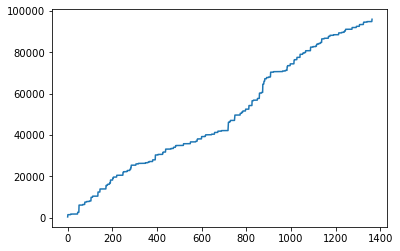

87613

In [4]:
fp_list = [i for i in range(len(ts.fp)) if ts.fp.iloc[i]]

plt.plot(fp_list)
plt.show()

j = np.random.choice(fp_list)
j


In [5]:
N = len(ts)
ts_test = ts.iloc[:N//5]
ts_train = ts.iloc[N//5:]
tau = 6

exogenous = ["a","b","c","A","B","C"]
no_exogen = len(exogenous)

lag = 12

N_train = len(ts_train)
X_train = np.vstack([ts_train["yy"].values[l:N_train-tau-lag+l] for l in range(1+lag)]).T
if no_exogen > 0:
    X_train = np.hstack([X_train,ts_train[exogenous].values[:N_train-tau-lag]])
#Y_train = ts_train["yy"].values[lag+tau:]
Y_train = np.vstack([ts_train["yy"].values[lag+t+1:N_train-tau+t+1] for t in range(tau)]).T

#X_test = ts_test[features].iloc[:-tau] 
#Y_test = ts_test["yy"].iloc[tau:]

N_test = len(ts_test)
X_test = np.vstack([ts_test["yy"].values[l:N_test-tau-lag+l] for l in range(1+lag)]).T
if no_exogen > 0:
    X_test = np.hstack([X_test,ts_test[exogenous].values[:N_test-tau-lag]])
#Y_test = ts_test["yy"].values[lag+tau:]
Y_test = np.vstack([ts_test["yy"].values[lag+t+1:N_test-tau+t+1] for t in range(tau)]).T

#plt.plot(X_train[:50,:1+lag])
#plt.plot(Y_train[:50], '--')
#plt.show()
#plt.plot(X_test[:50,:1+lag])
#plt.plot(Y_test[:50], '--')
#plt.show()

no_features = no_exogen + 1 + lag

N_train, X_train.shape, Y_train.shape, N_test, X_test.shape, Y_test.shape, no_features


(76952, (76934, 19), (76934, 6), 19238, (19220, 19), (19220, 6), 19)

In [6]:
def mdn_cost(mu_, sigma_, y_):
    #mu_ = Flatten()(mu)
    #sigma_ = Flatten()(sigma)
    #y_ = Flatten()(y)
    dist = tfp.distributions.Normal(loc=mu_, scale=sigma_)
    return tf.reduce_mean(-dist.log_prob(y_))


In [7]:
learning_rate = 0.0003

hidden_width = 30 + tau*2

InputLayer = Input(shape=(no_features,))
#Layer_1 = Dense(12,activation="tanh")(InputLayer)
#Layer_2 = Dense(12,activation="tanh")(Layer_1)
Layer_0 = Dense(hidden_width,activation="relu")(InputLayer)
#Layer_1 = Layer_0
Layer_1 = Dense(hidden_width,activation="relu")(Layer_0)
Layer_2 = Dense(hidden_width,activation="relu")(Layer_1)
mu = Dense(tau, activation="linear")(Layer_2)
sigma = Dense(tau, activation=lambda x: tf.nn.elu(x) + 1.001)(Layer_2)
y_real = Input(shape=(tau,))
lossF = mdn_cost(mu,sigma,y_real)
model = Model(inputs=[InputLayer, y_real], outputs=[mu, sigma])
model.add_loss(lossF)
adamOptimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adamOptimizer,metrics=['mse'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 19)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 42)           840         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 42)           1806        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 42)           1806        ['dense_1[0][0]']                
                                                                                              

2022-05-08 05:37:15.808108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-08 05:37:15.808151: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-08 05:37:15.808186: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-05-08 05:37:15.808467: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
model = keras.models.load_model('models/ah78_long_30_3')


In [44]:
if True: # Finetune
    epochs = 10
    batch_size = 50

    history_cache = model.fit([X_train, Y_train], #notice we are using an input to pass the real values due to the inner workings of keras
                              verbose=0, # write =1 if you wish to see the progress for each epoch
                              epochs=epochs,
                              batch_size=batch_size)
    print('Final cost: {0:.4f}'.format(history_cache.history['loss'][-1]))
    lbl = "tune%i"%epochs
else:
    lbl = "direct"


Final cost: 0.2158


In [34]:
mu_pred, sigma_pred = model.predict(list((X_test,Y_test))) # the model expects a list of arrays as it has 2 inputs
mu_pred.shape, sigma_pred.shape

((19220, 6), (19220, 6))

In [35]:
j = 500
savename = "figs/transfer/"+filename.split(".")[0]+"_30_3_"+lbl
savename


'figs/transfer/ah25_long_30_3_tune5'

In [36]:
#model.save('models/'+filename.split(".")[0]+"_30_3")


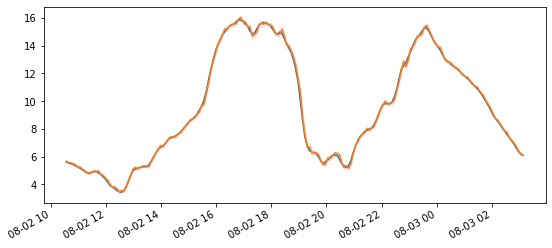

In [37]:
t = 1
time_index = ts_test.index[lag+t:]
predicted_mean = mu_pred[:,0]
predicted_sigma = sigma_pred[:,0]

time_index.shape

fig, ax = plt.subplots(figsize=(9,4))
ts_test.loc[time_index[j-100:j+100]]["yy"].plot()

plt.plot(time_index[j-100:j+100], predicted_mean[j-100:j+100])
upper = (predicted_mean + predicted_sigma)[j-100:j+100]
lower = (predicted_mean - predicted_sigma)[j-100:j+100]
ax.fill_between(time_index[j-100:j+100], upper, lower, color='r', alpha=0.1)

#plt.plot(ts.index[j-100:j+100], predict_dy.predicted_mean[j-100:j+100])
#ci = predict_dy_ci.values
#ax.fill_between(ts.index[j-100:j+100], ci[j-100:j+100,0], ci[j-100:j+100,1], color='g', alpha=0.1)

plt.savefig(savename+"_tau%i.png"%t)

plt.show()

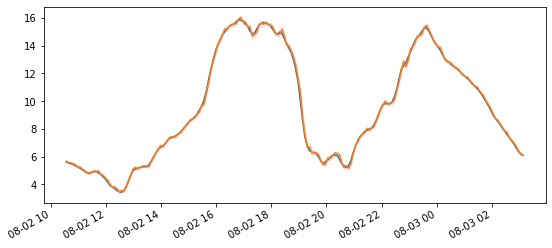

In [38]:
time_index = ts_test.index[lag+1:]
predicted_mean = mu_pred[:,0]
predicted_sigma = sigma_pred[:,0]

fig, ax = plt.subplots(figsize=(9,4))
ts_test.loc[time_index[j-100:j+100]]["yy"].plot()

plt.plot(time_index[j-100:j+100], predicted_mean[j-100:j+100])
upper = (predicted_mean + predicted_sigma)[j-100:j+100]
lower = (predicted_mean - predicted_sigma)[j-100:j+100]
ax.fill_between(time_index[j-100:j+100], upper, lower, color='r', alpha=0.1)

#plt.plot(ts.index[j-100:j+100], predict_dy.predicted_mean[j-100:j+100])
#ci = predict_dy_ci.values
#ax.fill_between(ts.index[j-100:j+100], ci[j-100:j+100,0], ci[j-100:j+100,1], color='g', alpha=0.1)
plt.savefig(savename+"_tau%i.png"%t)

plt.show()


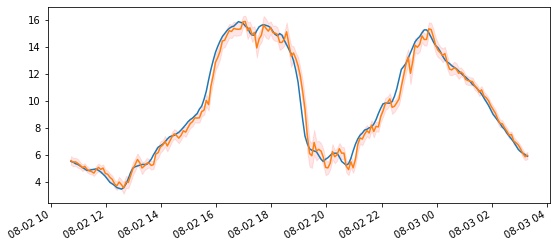

In [39]:
t = 3 # tau
time_index = ts_test.index[lag+t:]
predicted_mean = mu_pred[:,t-1]
predicted_sigma = sigma_pred[:,t-1]

time_index.shape

fig, ax = plt.subplots(figsize=(9,4))
ts_test.loc[time_index[j-100:j+100]]["yy"].plot()

plt.plot(time_index[j-100:j+100], predicted_mean[j-100:j+100])
upper = (predicted_mean + predicted_sigma)[j-100:j+100]
lower = (predicted_mean - predicted_sigma)[j-100:j+100]
ax.fill_between(time_index[j-100:j+100], upper, lower, color='r', alpha=0.1)

#plt.plot(ts.index[j-100:j+100], predict_dy.predicted_mean[j-100:j+100])
#ci = predict_dy_ci.values
#ax.fill_between(ts.index[j-100:j+100], ci[j-100:j+100,0], ci[j-100:j+100,1], color='g', alpha=0.1)
plt.savefig(savename+"_tau%i.png"%t)

plt.show()


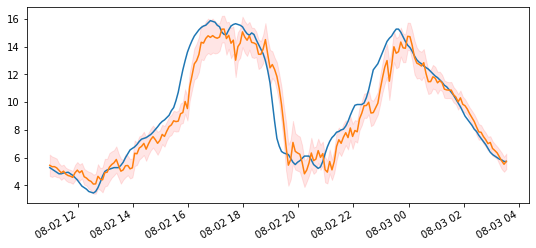

In [40]:
t = tau
time_index = ts_test.index[lag+t:]
predicted_mean = mu_pred[:,tau-1]
predicted_sigma = sigma_pred[:,tau-1]

time_index.shape

fig, ax = plt.subplots(figsize=(9,4))
ts_test.loc[time_index[j-100:j+100]]["yy"].plot()

plt.plot(time_index[j-100:j+100], predicted_mean[j-100:j+100])
upper = (predicted_mean + predicted_sigma)[j-100:j+100]
lower = (predicted_mean - predicted_sigma)[j-100:j+100]
ax.fill_between(time_index[j-100:j+100], upper, lower, color='r', alpha=0.1)

#plt.plot(ts.index[j-100:j+100], predict_dy.predicted_mean[j-100:j+100])
#ci = predict_dy_ci.values
#ax.fill_between(ts.index[j-100:j+100], ci[j-100:j+100,0], ci[j-100:j+100,1], color='g', alpha=0.1)
plt.savefig(savename+"_tau%i.png"%t)

plt.show()

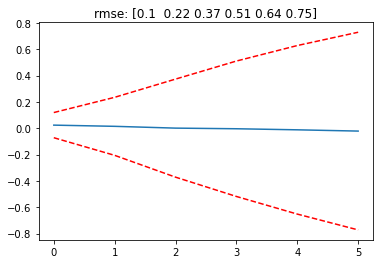

rmse [0.1  0.22 0.37 0.51 0.64 0.75]


In [41]:
err = mu_pred - Y_test
avg = err.mean(axis=0)
std = err.std(axis=0)
plt.plot(avg)
plt.plot(avg+std,'r--')
plt.plot(avg-std,'r--')
plt.title("rmse: "+str(np.round(np.sqrt(avg**2+std**2),2)))
plt.savefig(savename+"_cone.png")
plt.show()

print("rmse", np.round(np.sqrt(avg**2+std**2),2))


In [42]:
print("rmse", np.round(np.sqrt(avg**2+std**2),2),np.round(np.sqrt(avg**2+std**2),2).mean())


rmse [0.1  0.22 0.37 0.51 0.64 0.75] 0.43166666666666664


In [32]:
print("rmse", np.round(np.sqrt(avg**2+std**2),2),np.round(np.sqrt(avg**2+std**2),2).mean())


rmse_per [0.1  0.23 0.39 0.54 0.68 0.8 ] 0.4566666666666667
rmse_per [0.2  0.39 0.55 0.7  0.83 0.94] 0.6016666666666667
